# Pairs Trading Strategy: A Cointegration-Based Approach
## IEOR 198 Final Project

This notebook implements a market-neutral pairs trading strategy using cointegration analysis on S&P 500 stocks. The strategy identifies statistically related stock pairs and trades on mean reversion when their price relationship diverges from historical norms.


In [10]:
# Imports
import datetime as dt
import pandas as pd
import numpy as np
import warnings
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
from scipy.stats import zscore
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("All imports loaded successfully!")


All imports loaded successfully!


## 1. Data Collection

We'll download 2+ years of adjusted close prices for a subset of S&P 500 stocks using yfinance. To keep computation tractable for pairs screening, we focus on stocks from specific sectors.


In [11]:
# Define S&P 500 tickers by sector for pairs trading
# We focus on sectors where pairs trading works well (similar business models)

# Technology sector
tech_tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'CRM', 'ADBE', 'ORCL']

# Financial sector
financial_tickers = ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'USB', 'PNC', 'TFC', 'COF']

# Consumer Discretionary
consumer_tickers = ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'SBUX', 'TGT', 'LOW', 'TJX', 'ROST']

# Energy sector
energy_tickers = ['XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PSX', 'VLO', 'OXY', 'HAL']

# Combine all tickers
all_tickers = tech_tickers + financial_tickers + consumer_tickers + energy_tickers

# Create sector mapping for later use
sector_map = {}
for t in tech_tickers: sector_map[t] = 'Technology'
for t in financial_tickers: sector_map[t] = 'Financial'
for t in consumer_tickers: sector_map[t] = 'Consumer'
for t in energy_tickers: sector_map[t] = 'Energy'

print(f"Total tickers: {len(all_tickers)}")
print(f"Sectors: {list(set(sector_map.values()))}")


Total tickers: 40
Sectors: ['Technology', 'Financial', 'Energy', 'Consumer']


In [12]:
# Download historical price data
# Using 2+ years of data for robust cointegration testing

start_date = '2022-01-01'
end_date = '2024-12-01'

print(f"Downloading data from {start_date} to {end_date}...")

# Download adjusted close prices for all tickers
# Note: yfinance 2.x changed the column structure - we handle both old and new versions
try:
    raw_data = yf.download(all_tickers, start=start_date, end=end_date, progress=True, auto_adjust=False)
    
    # Debug: print column structure
    print(f"\nRaw data columns type: {type(raw_data.columns)}")
    
    # Handle different yfinance versions and column structures
    if isinstance(raw_data.columns, pd.MultiIndex):
        # MultiIndex columns: try 'Adj Close' first, then 'Close'
        if 'Adj Close' in raw_data.columns.get_level_values(0):
            price_data = raw_data['Adj Close'].copy()
        elif 'Close' in raw_data.columns.get_level_values(0):
            price_data = raw_data['Close'].copy()
        else:
            # Fallback: take first level
            first_level = raw_data.columns.get_level_values(0)[0]
            price_data = raw_data[first_level].copy()
            print(f"Warning: Using '{first_level}' column as fallback")
    else:
        # Single-level columns (single ticker case)
        if 'Adj Close' in raw_data.columns:
            price_data = raw_data[['Adj Close']].copy()
            price_data.columns = [all_tickers[0]]
        elif 'Close' in raw_data.columns:
            price_data = raw_data[['Close']].copy()
            price_data.columns = [all_tickers[0]]
        else:
            price_data = raw_data.copy()

except Exception as e:
    print(f"Download error: {e}")
    # Try alternative download method with auto_adjust=True
    print("Attempting alternative download with auto_adjust=True...")
    try:
        raw_data = yf.download(all_tickers, start=start_date, end=end_date, progress=True, auto_adjust=True)
        if isinstance(raw_data.columns, pd.MultiIndex):
            price_data = raw_data['Close'].copy()
        else:
            price_data = raw_data[['Close']].copy() if 'Close' in raw_data.columns else raw_data.copy()
    except Exception as e2:
        print(f"Alternative download also failed: {e2}")
        price_data = pd.DataFrame()

# Forward fill then back fill small gaps, then drop columns with >5% missing
if len(price_data) > 0 and len(price_data.columns) > 0:
    price_data = price_data.ffill().bfill()
    
    # Drop columns (tickers) with more than 5% missing data
    missing_pct = price_data.isna().sum() / len(price_data)
    valid_tickers = missing_pct[missing_pct < 0.05].index.tolist()
    price_data = price_data[valid_tickers]
    
    # Drop any remaining rows with NaN
    price_data = price_data.dropna(axis=0)
    
    # Update sector_map to only include valid tickers
    sector_map = {t: sector_map[t] for t in valid_tickers if t in sector_map}

print(f"\nData shape: {price_data.shape}")
if len(price_data) > 0 and len(price_data.columns) > 0:
    print(f"Date range: {price_data.index[0].date()} to {price_data.index[-1].date()}")
    print(f"Tickers with complete data: {len(price_data.columns)}")
    print(f"Tickers: {list(price_data.columns)}")
else:
    print("ERROR: No data downloaded. Please check your internet connection.")
price_data.head()

[**                     5%                       ]  2 of 40 completed

[*********************100%***********************]  40 of 40 completed



Raw data columns type: <class 'pandas.core.indexes.multi.MultiIndex'>

Data shape: (732, 40)
Date range: 2022-01-03 to 2024-11-29
Tickers with complete data: 40
Tickers: ['AAPL', 'ADBE', 'AMD', 'AMZN', 'BAC', 'C', 'COF', 'COP', 'CRM', 'CVX', 'EOG', 'GOOGL', 'GS', 'HAL', 'HD', 'INTC', 'JPM', 'LOW', 'MCD', 'META', 'MPC', 'MS', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PNC', 'PSX', 'ROST', 'SBUX', 'SLB', 'TFC', 'TGT', 'TJX', 'TSLA', 'USB', 'VLO', 'WFC', 'XOM']


Ticker,AAPL,ADBE,AMD,AMZN,BAC,C,COF,COP,CRM,CVX,EOG,GOOGL,GS,HAL,HD,INTC,JPM,LOW,MCD,META,MPC,MS,MSFT,NKE,NVDA,ORCL,OXY,PNC,PSX,ROST,SBUX,SLB,TFC,TGT,TJX,TSLA,USB,VLO,WFC,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-03,178.270340,564.369995,150.240005,170.404495,41.714245,54.393017,137.953278,63.700054,252.800781,101.482422,75.843277,143.904205,357.215729,22.102228,369.339630,49.350483,145.583237,236.385452,245.086426,336.465790,59.946762,87.451149,323.898346,154.498703,30.062769,83.251686,29.309277,178.487823,65.250221,108.066177,105.978012,28.991653,49.310791,204.657120,71.196556,399.926666,48.126862,67.911430,45.828438,55.125233
2022-01-04,176.007812,554.000000,144.419998,167.522003,43.349216,54.815403,140.566528,66.463211,245.646027,103.328964,79.329269,143.316650,368.194397,23.428913,373.135620,49.285564,151.102249,240.363586,245.022537,334.468109,61.909676,91.003670,318.344482,156.112473,29.233372,84.141968,31.498510,185.062592,67.688271,108.066177,103.761810,30.399187,50.902767,206.615921,72.299141,383.196655,49.387386,69.117500,47.653255,57.198723
2022-01-05,171.325989,514.429993,136.149994,164.356995,42.617538,54.177517,137.878891,65.323395,225.300049,104.001198,77.873306,136.741821,360.197693,23.198584,368.074280,49.962612,148.339813,235.682297,243.817978,322.183838,62.302261,88.751686,306.123932,152.228180,27.550632,81.887833,30.016998,182.062378,67.472885,104.723717,100.310349,30.399187,50.347614,201.930679,70.810188,362.706665,49.126877,68.844612,47.237705,57.910118
2022-01-06,168.465973,514.119995,136.229996,163.253998,43.475666,55.953262,140.175919,67.775749,226.764633,104.886185,79.470695,136.714508,358.661499,23.594751,366.736572,50.092457,149.915756,238.494812,246.099335,330.423065,64.046082,90.270462,303.704926,151.092911,28.123522,82.077950,30.913448,189.074326,69.333755,104.513611,100.946129,31.121235,52.233509,204.127716,71.121178,354.899994,50.463032,70.570122,48.448235,59.272213
2022-01-07,168.632507,510.700012,132.000000,162.554001,44.424129,56.703213,143.858658,69.632240,225.933365,106.392326,81.667130,135.989487,359.185608,23.972485,355.755035,49.563805,151.401154,232.296280,243.699356,329.757141,64.758217,90.820366,303.859741,147.274307,27.194324,83.190201,31.338083,191.783127,70.608772,100.263924,97.703590,32.016941,53.066238,203.624817,70.093971,342.320007,51.261364,71.309624,49.478085,59.758038


In [13]:
# Calculate log returns for analysis
if len(price_data) > 0 and len(price_data.columns) > 0:
    log_returns = np.log(price_data / price_data.shift(1)).dropna()
    print(f"Log returns shape: {log_returns.shape}")
    if len(log_returns.columns) > 0:
        print("\nSample statistics:")
        display(log_returns.describe())
    else:
        print("ERROR: Log returns DataFrame has no columns.")
else:
    print("ERROR: No price data available. Cannot calculate returns.")
    log_returns = pd.DataFrame()

Log returns shape: (731, 40)

Sample statistics:


Ticker,AAPL,ADBE,AMD,AMZN,BAC,C,COF,COP,CRM,CVX,EOG,GOOGL,GS,HAL,HD,INTC,JPM,LOW,MCD,META,MPC,MS,MSFT,NKE,NVDA,ORCL,OXY,PNC,PSX,ROST,SBUX,SLB,TFC,TGT,TJX,TSLA,USB,VLO,WFC,XOM
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.000385,-0.000123,-0.000124,0.000272,0.000139,0.000325,0.000435,0.000680,0.000356,0.000577,0.000725,0.000213,0.000694,0.000453,0.000172,-0.000983,0.000709,0.000167,0.000219,0.000727,0.001280,0.000521,0.000357,-0.000960,0.002087,0.001078,0.000710,0.000203,0.000934,0.000474,-0.000082,0.000518,-0.000112,-0.000656,0.000761,-0.000201,0.000079,0.000938,0.000666,0.000991
std,0.017194,0.024036,0.033275,0.024326,0.017445,0.018030,0.022400,0.020716,0.024274,0.016311,0.021405,0.020579,0.016713,0.025098,0.015807,0.027818,0.015794,0.017014,0.011008,0.031447,0.020333,0.017790,0.017497,0.022247,0.034746,0.019459,0.023757,0.018228,0.019947,0.020190,0.020378,0.024075,0.021992,0.025323,0.014825,0.038444,0.020424,0.022990,0.019025,0.017308
min,-0.060471,-0.183841,-0.149299,-0.151398,-0.065858,-0.077392,-0.085713,-0.102486,-0.219863,-0.069570,-0.114291,-0.099924,-0.072216,-0.112975,-0.092670,-0.301896,-0.066864,-0.063867,-0.052584,-0.306390,-0.098397,-0.070256,-0.080295,-0.222905,-0.105412,-0.144972,-0.115783,-0.070111,-0.079405,-0.254509,-0.172896,-0.123259,-0.186243,-0.286754,-0.069690,-0.131643,-0.105853,-0.086716,-0.073997,-0.082135
25%,-0.008580,-0.011524,-0.019173,-0.013041,-0.010124,-0.010701,-0.011741,-0.010621,-0.012024,-0.008007,-0.009964,-0.011887,-0.008509,-0.012437,-0.008948,-0.016235,-0.007431,-0.008810,-0.006194,-0.011795,-0.009170,-0.008965,-0.008965,-0.011181,-0.018850,-0.008863,-0.011192,-0.010651,-0.009544,-0.008819,-0.009340,-0.011810,-0.012170,-0.011369,-0.007048,-0.020585,-0.010438,-0.011808,-0.009793,-0.008930
50%,0.000787,-0.000258,-0.000881,0.000318,-0.000842,0.000326,-0.000073,0.000553,0.000693,0.001182,0.000930,0.001139,0.000474,0.001437,0.000733,0.000233,0.001353,0.000504,0.000227,0.000902,0.001995,0.000600,0.000846,-0.000103,0.003483,0.001128,0.000000,0.000614,0.000837,0.000265,-0.000389,0.001304,0.000000,-0.000506,0.000814,0.000964,-0.000266,0.001577,0.000412,0.001261
75%,0.009687,0.013265,0.020184,0.014020,0.008780,0.009860,0.013399,0.012317,0.013378,0.009496,0.011580,0.011189,0.010235,0.014688,0.009416,0.014122,0.008891,0.009485,0.006167,0.014444,0.012871,0.010309,0.010643,0.010429,0.021920,0.010448,0.011452,0.010675,0.012877,0.009072,0.008615,0.013120,0.012286,0.010826,0.008254,0.020354,0.011231,0.014372,0.010694,0.011753
max,0.085236,0.135505,0.133385,0.126949,0.080924,0.124256,0.139827,0.088774,0.108826,0.085292,0.070823,0.097348,0.123083,0.085504,0.083431,0.101279,0.109254,0.090559,0.040063,0.209308,0.075084,0.109858,0.079059,0.114926,0.218088,0.125040,0.162048,0.082175,0.066104,0.094075,0.219111,0.098310,0.104888,0.163430,0.068767,0.198187,0.085365,0.076922,0.123196,0.062142


## 2. Pair Selection via Cointegration

**Cointegration** is a statistical property where two non-stationary time series share a common stochastic trend. Unlike correlation (which measures co-movement), cointegration implies a stable long-run equilibrium relationship.

We use the **Engle-Granger two-step cointegration test**:
1. Run OLS regression: Y_t = alpha + beta * X_t + epsilon_t
2. Test residuals for stationarity using ADF test

A p-value < 0.05 indicates the pair is likely cointegrated.


In [14]:
def find_cointegrated_pairs(data, sector_map, significance=0.05):
    """
    Find cointegrated pairs within the same sector using Engle-Granger test.
    
    Returns:
        DataFrame with pair info sorted by p-value
    """
    tickers = data.columns.tolist()
    n = len(tickers)
    pairs_results = []
    
    # Only test pairs within the same sector (fundamental justification)
    for i in range(n):
        for j in range(i+1, n):
            ticker1, ticker2 = tickers[i], tickers[j]
            
            # Check if same sector
            if sector_map.get(ticker1) != sector_map.get(ticker2):
                continue
                
            # Run cointegration test
            score, pvalue, _ = coint(data[ticker1], data[ticker2])
            
            if pvalue < significance:
                pairs_results.append({
                    'ticker1': ticker1,
                    'ticker2': ticker2,
                    'sector': sector_map.get(ticker1, 'Unknown'),
                    'pvalue': pvalue,
                    't_statistic': score
                })
    
    # Sort by p-value (most significant first)
    pairs_df = pd.DataFrame(pairs_results).sort_values('pvalue')
    return pairs_df

print("Cointegration function defined.")


Cointegration function defined.


In [15]:
# Split data into training (80%) and testing (20%) periods
# We use training data for pair selection to avoid lookahead bias

if len(price_data) > 0:
    train_size = int(len(price_data) * 0.8)
    train_data = price_data.iloc[:train_size]
    test_data = price_data.iloc[train_size:]
    
    print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()} ({len(train_data)} days)")
    print(f"Testing period: {test_data.index[0].date()} to {test_data.index[-1].date()} ({len(test_data)} days)")
else:
    print("ERROR: No price data available for train/test split.")
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()


Training period: 2022-01-03 to 2024-05-01 (585 days)
Testing period: 2024-05-02 to 2024-11-29 (147 days)


In [16]:
# Find cointegrated pairs using training data only
if len(train_data) > 0 and len(train_data.columns) >= 2:
    print("Screening for cointegrated pairs (this may take a moment)...\n")
    
    cointegrated_pairs = find_cointegrated_pairs(train_data, sector_map, significance=0.05)
    
    print(f"Found {len(cointegrated_pairs)} cointegrated pairs:\n")
    display(cointegrated_pairs) if len(cointegrated_pairs) > 0 else print("No pairs found at 0.05 significance level.")
else:
    print("ERROR: Not enough data to screen for pairs.")
    cointegrated_pairs = pd.DataFrame()


Screening for cointegrated pairs (this may take a moment)...

Found 21 cointegrated pairs:



,ticker1,ticker2,sector,pvalue,t_statistic
0,AMD,CRM,Technology,0.000322,-4.839107
3,CRM,META,Technology,0.005614,-4.074112
11,HD,ROST,Consumer,0.005670,-4.071151
4,CRM,MSFT,Technology,0.006514,-4.029583
16,META,NVDA,Technology,0.010267,-3.889135
15,META,MSFT,Technology,0.012152,-3.835398
8,EOG,MPC,Energy,0.012466,-3.827173
12,HD,TJX,Consumer,0.013406,-3.803621
19,OXY,PSX,Energy,0.013933,-3.791046
18,NKE,TJX,Consumer,0.017856,-3.708756


Best pair: AMD - CRM
Sector: Technology
Cointegration p-value: 0.000322


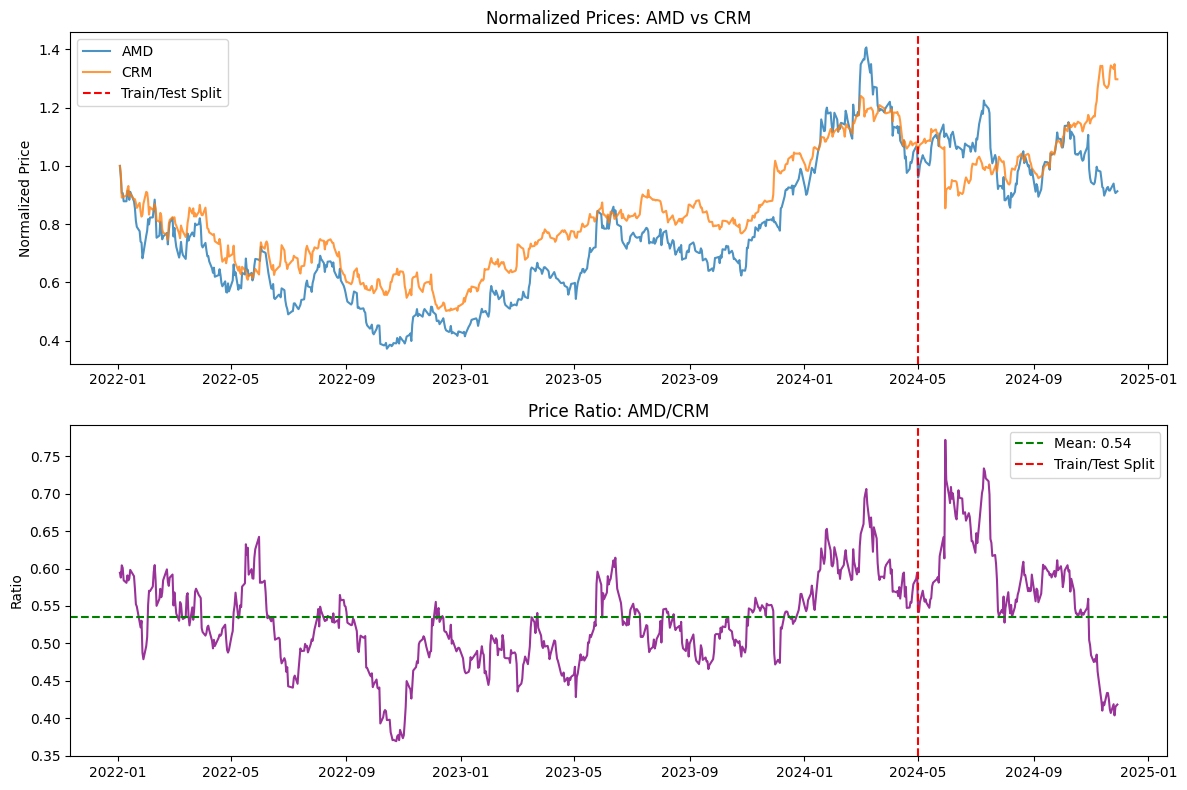

In [17]:
# Select top pair(s) for trading
# If no pairs found, use a default pair known to be historically cointegrated

available_tickers = list(price_data.columns) if len(price_data) > 0 else []

if len(cointegrated_pairs) > 0:
    best_pair = cointegrated_pairs.iloc[0]
    stock1, stock2 = best_pair['ticker1'], best_pair['ticker2']
    print(f"Best pair: {stock1} - {stock2}")
    print(f"Sector: {best_pair['sector']}")
    print(f"Cointegration p-value: {best_pair['pvalue']:.6f}")
else:
    # Fallback to a commonly traded pair (energy sector usually has good pairs)
    fallback_pairs = [('XOM', 'CVX'), ('JPM', 'BAC'), ('AAPL', 'MSFT'), ('HD', 'LOW')]
    stock1, stock2 = None, None
    
    for s1, s2 in fallback_pairs:
        if s1 in available_tickers and s2 in available_tickers:
            stock1, stock2 = s1, s2
            break
    
    if stock1 is None and len(available_tickers) >= 2:
        # Just use first two available tickers
        stock1, stock2 = available_tickers[0], available_tickers[1]
    
    if stock1 and stock2:
        print(f"No significant pairs found at 0.05 level. Using fallback pair: {stock1} - {stock2}")
    else:
        print("ERROR: Not enough tickers available to form a pair.")

# Visualize the price series (normalized)
if stock1 and stock2 and stock1 in price_data.columns and stock2 in price_data.columns:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Normalized prices
    norm_s1 = price_data[stock1] / price_data[stock1].iloc[0]
    norm_s2 = price_data[stock2] / price_data[stock2].iloc[0]
    
    axes[0].plot(norm_s1, label=stock1, alpha=0.8)
    axes[0].plot(norm_s2, label=stock2, alpha=0.8)
    if len(train_data) > 0:
        axes[0].axvline(train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
    axes[0].set_title(f'Normalized Prices: {stock1} vs {stock2}')
    axes[0].legend()
    axes[0].set_ylabel('Normalized Price')
    
    # Price ratio
    ratio = price_data[stock1] / price_data[stock2]
    axes[1].plot(ratio, color='purple', alpha=0.8)
    axes[1].axhline(ratio.mean(), color='green', linestyle='--', label=f'Mean: {ratio.mean():.2f}')
    if len(train_data) > 0:
        axes[1].axvline(train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
    axes[1].set_title(f'Price Ratio: {stock1}/{stock2}')
    axes[1].legend()
    axes[1].set_ylabel('Ratio')
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot visualize - missing stock data.")


## 3. Spread Modeling and Signal Generation

The trading signal is based on the **z-score** of the price spread (or ratio). When the z-score deviates significantly from zero, we expect mean reversion:

- **Entry Signal (Long spread)**: z-score < -2 (spread is unusually low, expect it to rise)
- **Entry Signal (Short spread)**: z-score > +2 (spread is unusually high, expect it to fall)
- **Exit Signal**: z-score crosses back through 0

We use a **rolling window** to calculate the z-score to adapt to changing market conditions.


In [18]:
# Calculate the hedge ratio using OLS regression on training data
# This tells us how many shares of stock2 to trade per share of stock1

if stock1 and stock2 and len(train_data) > 0 and stock1 in train_data.columns and stock2 in train_data.columns:
    X = sm.add_constant(train_data[stock2])
    model = sm.OLS(train_data[stock1], X).fit()
    hedge_ratio = model.params[stock2]
    intercept = model.params['const']
    
    print(f"Hedge Ratio (beta): {hedge_ratio:.4f}")
    print(f"Intercept (alpha): {intercept:.4f}")
    print(f"R-squared: {model.rsquared:.4f}")
else:
    print("ERROR: Cannot calculate hedge ratio - missing data.")
    hedge_ratio = 1.0
    intercept = 0.0


Hedge Ratio (beta): 0.7133
Intercept (alpha): -36.5809
R-squared: 0.9277


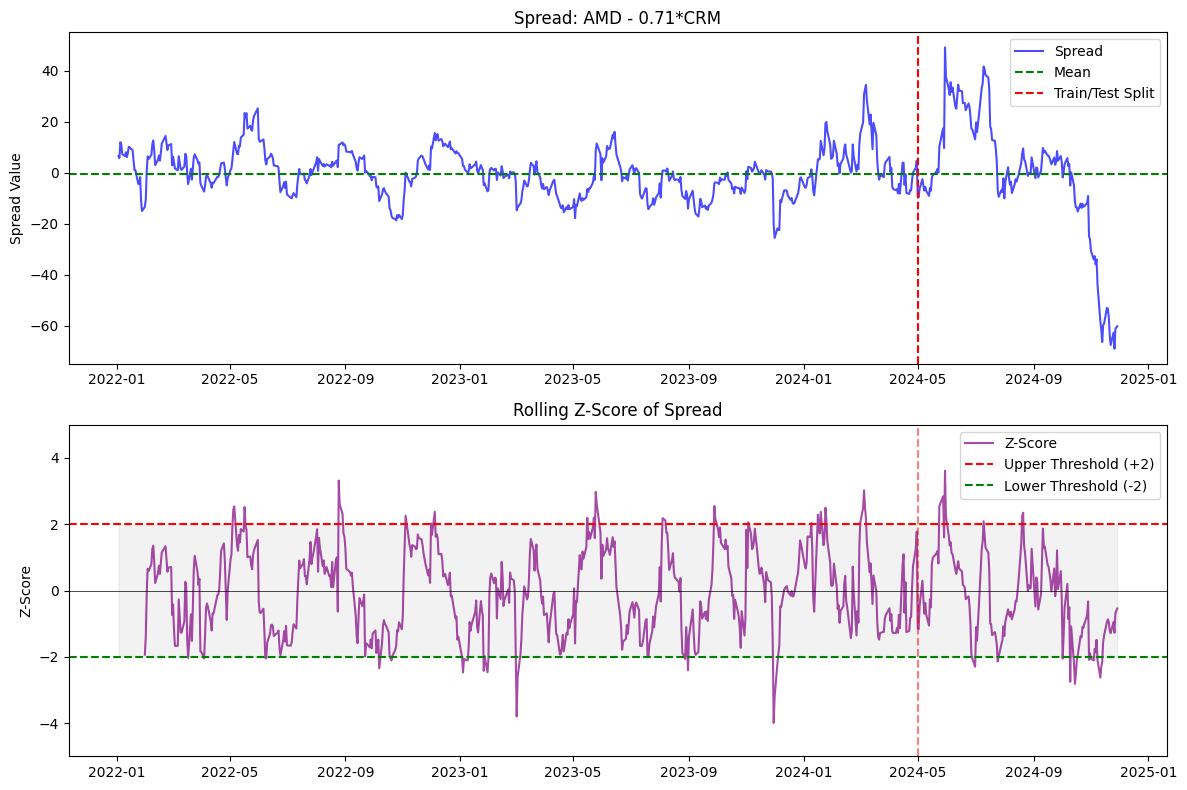

In [19]:
# Calculate spread: S1 - beta * S2 - alpha
# The spread should be stationary if the pair is cointegrated

if stock1 and stock2 and stock1 in price_data.columns and stock2 in price_data.columns:
    spread = price_data[stock1] - hedge_ratio * price_data[stock2] - intercept
    
    # Calculate rolling z-score
    # Using 20-day window (approximately 1 month of trading)
    lookback = 20
    
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    zscore_spread = (spread - rolling_mean) / rolling_std
    
    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Spread
    axes[0].plot(spread, label='Spread', color='blue', alpha=0.7)
    axes[0].axhline(spread.mean(), color='green', linestyle='--', label='Mean')
    if len(train_data) > 0:
        axes[0].axvline(train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
    axes[0].set_title(f'Spread: {stock1} - {hedge_ratio:.2f}*{stock2}')
    axes[0].legend()
    axes[0].set_ylabel('Spread Value')
    
    # Z-score
    axes[1].plot(zscore_spread, label='Z-Score', color='purple', alpha=0.7)
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[1].axhline(2, color='red', linestyle='--', label='Upper Threshold (+2)')
    axes[1].axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
    if len(train_data) > 0:
        axes[1].axvline(train_data.index[-1], color='red', linestyle='--', alpha=0.5)
    axes[1].fill_between(zscore_spread.index, -2, 2, alpha=0.1, color='gray')
    axes[1].set_title('Rolling Z-Score of Spread')
    axes[1].legend()
    axes[1].set_ylabel('Z-Score')
    axes[1].set_ylim(-5, 5)
    
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: Cannot calculate spread - missing stock data.")
    spread = pd.Series()
    zscore_spread = pd.Series()
    lookback = 20


In [20]:
# Generate trading signals
# Position: 1 = long spread (long S1, short S2), -1 = short spread (short S1, long S2), 0 = no position

entry_threshold = 2.0
exit_threshold = 0.0

def generate_signals(zscore, entry_thresh=2.0, exit_thresh=0.0):
    """
    Generate trading signals based on z-score thresholds.
    
    Long spread when z-score < -entry_thresh (spread is cheap, expect increase)
    Short spread when z-score > +entry_thresh (spread is expensive, expect decrease)
    Exit when z-score crosses exit_thresh (mean reversion complete)
    """
    if len(zscore) == 0:
        return pd.Series()
    
    signals = pd.Series(index=zscore.index, data=0.0)
    position = 0
    
    for i in range(len(zscore)):
        if pd.isna(zscore.iloc[i]):
            signals.iloc[i] = 0
            continue
            
        z = zscore.iloc[i]
        
        if position == 0:  # No position
            if z < -entry_thresh:
                position = 1  # Long spread (expect z to increase)
            elif z > entry_thresh:
                position = -1  # Short spread (expect z to decrease)
        elif position == 1:  # Long spread
            if z > exit_thresh:
                position = 0  # Exit
        elif position == -1:  # Short spread
            if z < exit_thresh:
                position = 0  # Exit
                
        signals.iloc[i] = position
    
    return signals

if len(zscore_spread) > 0:
    signals = generate_signals(zscore_spread, entry_threshold, exit_threshold)
    
    print(f"Total trading days: {len(signals)}")
    print(f"Days in long position: {(signals == 1).sum()}")
    print(f"Days in short position: {(signals == -1).sum()}")
    print(f"Days with no position: {(signals == 0).sum()}")
else:
    print("ERROR: Cannot generate signals - no z-score data available.")
    signals = pd.Series()


Total trading days: 732
Days in long position: 169
Days in short position: 175
Days with no position: 388


## 4. Backtesting Framework

We simulate the strategy with the following assumptions:
- **Equal dollar allocation** to each leg (long and short)
- **Transaction costs**: 0.02% per trade (matching the lab)
- **No leverage**: Net dollar exposure is approximately zero (market neutral)
- **Daily rebalancing**: Position sizes adjusted based on price changes

The strategy P&L comes from the spread returning to its mean value.


In [21]:
# Build the backtesting dataframe
if len(signals) > 0 and stock1 in price_data.columns and stock2 in price_data.columns:
    backtest_df = pd.DataFrame({
        'date': price_data.index,
        'price_s1': price_data[stock1].values,
        'price_s2': price_data[stock2].values,
        'spread': spread.values,
        'zscore': zscore_spread.values,
        'signal': signals.values
    }).set_index('date')
    
    # Calculate log returns for each stock
    backtest_df['ret_s1'] = np.log(backtest_df['price_s1'] / backtest_df['price_s1'].shift(1))
    backtest_df['ret_s2'] = np.log(backtest_df['price_s2'] / backtest_df['price_s2'].shift(1))
    
    # Calculate spread returns
    # When long spread: long S1, short S2 -> return = ret_s1 - ret_s2
    # When short spread: short S1, long S2 -> return = ret_s2 - ret_s1 = -(ret_s1 - ret_s2)
    backtest_df['spread_return'] = backtest_df['ret_s1'] - backtest_df['ret_s2']
    
    # Strategy return (delayed by 1 day since we trade on signal)
    backtest_df['signal_prev'] = backtest_df['signal'].shift(1)
    backtest_df['strategy_return'] = backtest_df['signal_prev'] * backtest_df['spread_return']
    
    display(backtest_df.head(10))
else:
    print("ERROR: Cannot build backtest dataframe - missing data.")
    backtest_df = pd.DataFrame()


,price_s1,price_s2,spread,zscore,signal,ret_s1,ret_s2,spread_return,signal_prev,strategy_return
date,,,,,,,,,,
2022-01-03,150.240005,252.800781,6.505575,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2022-01-04,144.419998,245.646027,5.788843,NaN,0.0,-0.039508,-0.028710,-0.010798,0.0,-0.0
2022-01-05,136.149994,225.300049,12.031027,NaN,0.0,-0.058969,-0.086459,0.027490,0.0,0.0
2022-01-06,136.229996,226.764633,11.066384,NaN,0.0,0.000587,0.006480,-0.005892,0.0,-0.0
2022-01-07,132.000000,225.933365,7.429307,NaN,0.0,-0.031543,-0.003673,-0.027870,0.0,-0.0
2022-01-10,132.000000,227.239639,6.497580,NaN,0.0,0.000000,0.005765,-0.005765,0.0,-0.0
2022-01-11,137.309998,232.395401,8.130124,NaN,0.0,0.039439,0.022435,0.017004,0.0,0.0
2022-01-12,137.470001,235.354263,6.179659,NaN,0.0,0.001165,0.012652,-0.011487,0.0,-0.0
2022-01-13,132.740005,226.250046,7.943433,NaN,0.0,-0.035013,-0.039451,0.004438,0.0,0.0


In [22]:
# Account for transaction costs
# We pay fees when we enter or exit a position (position changes)

fee_rate = 0.0002  # 0.02% per trade

if len(backtest_df) > 0:
    # Detect position changes
    backtest_df['position_change'] = backtest_df['signal'].diff().abs()
    
    # Fee is applied to both legs when position changes
    # Since we have two legs (long one stock, short another), fee is 2x
    backtest_df['fees'] = backtest_df['position_change'] * fee_rate * 2
    
    # Strategy return after fees
    backtest_df['strategy_return_net'] = backtest_df['strategy_return'] - backtest_df['fees']
    
    # Drop NaN rows
    backtest_df = backtest_df.dropna()
    
    # Count trades
    num_trades = (backtest_df['position_change'] > 0).sum()
    print(f"Total number of trades (entries + exits): {num_trades}")
    print(f"Total fees paid: {backtest_df['fees'].sum():.4%}")
else:
    print("ERROR: Cannot calculate fees - backtest dataframe is empty.")
    num_trades = 0


Total number of trades (entries + exits): 49
Total fees paid: 1.9600%


## 5. Results and Performance Analysis

We evaluate the strategy using multiple metrics:
- **Cumulative Returns**: Total P&L over the period
- **Sharpe Ratio**: Risk-adjusted returns (annualized)
- **Maximum Drawdown**: Largest peak-to-trough decline
- **Win Rate**: Percentage of profitable trades

We also compare in-sample (training) vs out-of-sample (testing) performance to assess robustness.


In [23]:
# Performance metric functions
def sharpe_ratio(returns, periods_per_year=252):
    """Calculate annualized Sharpe ratio"""
    if returns.std() == 0:
        return 0
    return (returns.mean() / returns.std()) * np.sqrt(periods_per_year)

def max_drawdown(cumulative_returns):
    """Calculate maximum drawdown"""
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    return drawdown.min()

def calculate_metrics(returns, label=""):
    """Calculate and print key performance metrics"""
    cum_return = returns.cumsum()
    total_return = np.exp(cum_return.iloc[-1]) - 1  # Convert log return to simple
    
    metrics = {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{(returns.mean() * 252):.2%}",
        'Volatility (Ann.)': f"{(returns.std() * np.sqrt(252)):.2%}",
        'Sharpe Ratio': f"{sharpe_ratio(returns):.2f}",
        'Max Drawdown': f"{max_drawdown(np.exp(cum_return)):.2%}",
        'Win Rate': f"{(returns > 0).sum() / (returns != 0).sum():.2%}" if (returns != 0).sum() > 0 else "N/A"
    }
    
    print(f"\n{'='*40}")
    print(f"  {label}")
    print(f"{'='*40}")
    for k, v in metrics.items():
        print(f"  {k:20}: {v}")
    
    return metrics

print("Performance functions defined.")


Performance functions defined.


In [24]:
# Split results into training and testing periods
if len(backtest_df) > 0 and len(train_data) > 0:
    train_end_date = train_data.index[-1]
    
    train_results = backtest_df[backtest_df.index <= train_end_date]
    test_results = backtest_df[backtest_df.index > train_end_date]
    
    # Calculate metrics for each period
    print("PAIRS TRADING STRATEGY PERFORMANCE")
    print(f"Pair: {stock1} / {stock2}")
    
    if len(train_results) > 0:
        train_metrics = calculate_metrics(train_results['strategy_return_net'], 
                                           f"IN-SAMPLE (Training: {train_results.index[0].date()} to {train_results.index[-1].date()})")
    else:
        print("No training results available.")
        train_metrics = {}
    
    if len(test_results) > 0:
        test_metrics = calculate_metrics(test_results['strategy_return_net'], 
                                          f"OUT-OF-SAMPLE (Testing: {test_results.index[0].date()} to {test_results.index[-1].date()})")
    else:
        print("No testing results available.")
        test_metrics = {}
    
    full_metrics = calculate_metrics(backtest_df['strategy_return_net'], 
                                      f"FULL PERIOD")
else:
    print("ERROR: Cannot calculate metrics - no backtest data available.")
    train_results = pd.DataFrame()
    test_results = pd.DataFrame()
    train_metrics = {}
    test_metrics = {}
    full_metrics = {}


PAIRS TRADING STRATEGY PERFORMANCE
Pair: AMD / CRM

  IN-SAMPLE (Training: 2022-01-31 to 2024-05-01)
  Total Return        : 20.57%
  Annualized Return   : 8.33%
  Volatility (Ann.)   : 30.07%
  Sharpe Ratio        : 0.28
  Max Drawdown        : -28.31%
  Win Rate            : 48.73%

  OUT-OF-SAMPLE (Testing: 2024-05-02 to 2024-11-29)
  Total Return        : -0.28%
  Annualized Return   : -0.47%
  Volatility (Ann.)   : 48.10%
  Sharpe Ratio        : -0.01
  Max Drawdown        : -31.14%
  Win Rate            : 49.46%

  FULL PERIOD
  Total Return        : 20.23%
  Annualized Return   : 6.51%
  Volatility (Ann.)   : 34.53%
  Sharpe Ratio        : 0.19
  Max Drawdown        : -31.14%
  Win Rate            : 48.91%


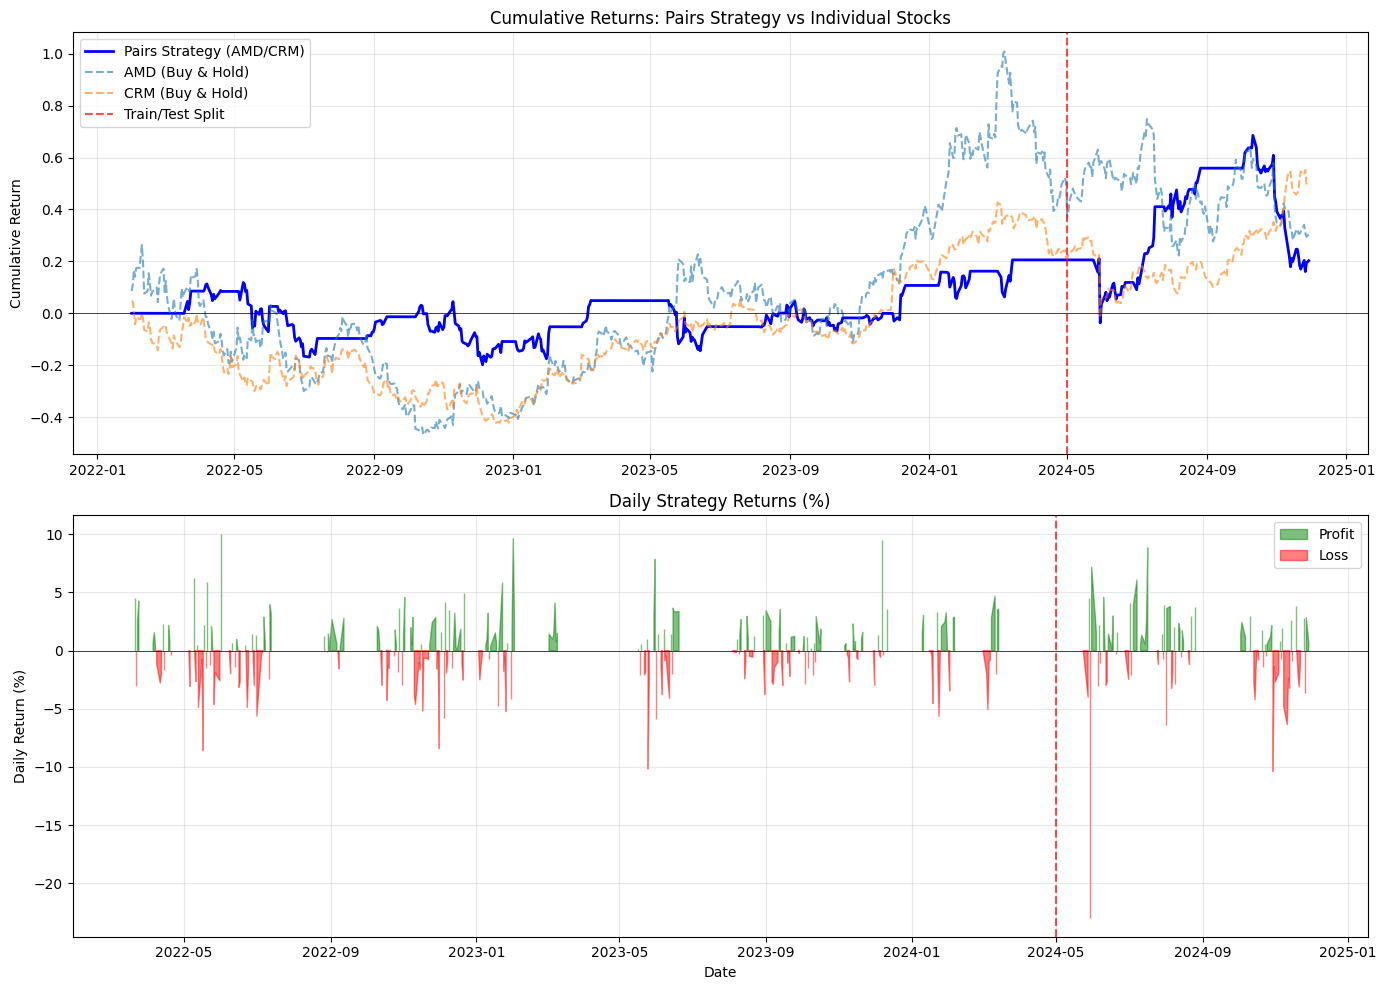

In [25]:
# Plot cumulative returns
if len(backtest_df) > 0 and 'strategy_return_net' in backtest_df.columns:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Cumulative returns comparison
    strategy_cum = backtest_df['strategy_return_net'].cumsum()
    s1_cum = backtest_df['ret_s1'].cumsum()
    s2_cum = backtest_df['ret_s2'].cumsum()
    
    # Convert to simple returns for plotting
    axes[0].plot(np.exp(strategy_cum) - 1, label=f'Pairs Strategy ({stock1}/{stock2})', linewidth=2, color='blue')
    axes[0].plot(np.exp(s1_cum) - 1, label=f'{stock1} (Buy & Hold)', alpha=0.6, linestyle='--')
    axes[0].plot(np.exp(s2_cum) - 1, label=f'{stock2} (Buy & Hold)', alpha=0.6, linestyle='--')
    if len(train_data) > 0:
        axes[0].axvline(train_end_date, color='red', linestyle='--', label='Train/Test Split', alpha=0.7)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_title('Cumulative Returns: Pairs Strategy vs Individual Stocks', fontsize=12)
    axes[0].set_ylabel('Cumulative Return')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Strategy returns with signals overlay
    ax2 = axes[1]
    ax2.fill_between(backtest_df.index, 0, backtest_df['strategy_return_net'] * 100, 
                      where=backtest_df['strategy_return_net'] > 0, color='green', alpha=0.5, label='Profit')
    ax2.fill_between(backtest_df.index, 0, backtest_df['strategy_return_net'] * 100, 
                      where=backtest_df['strategy_return_net'] < 0, color='red', alpha=0.5, label='Loss')
    if len(train_data) > 0:
        ax2.axvline(train_end_date, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title('Daily Strategy Returns (%)', fontsize=12)
    ax2.set_ylabel('Daily Return (%)')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: Cannot plot - no backtest data available.")


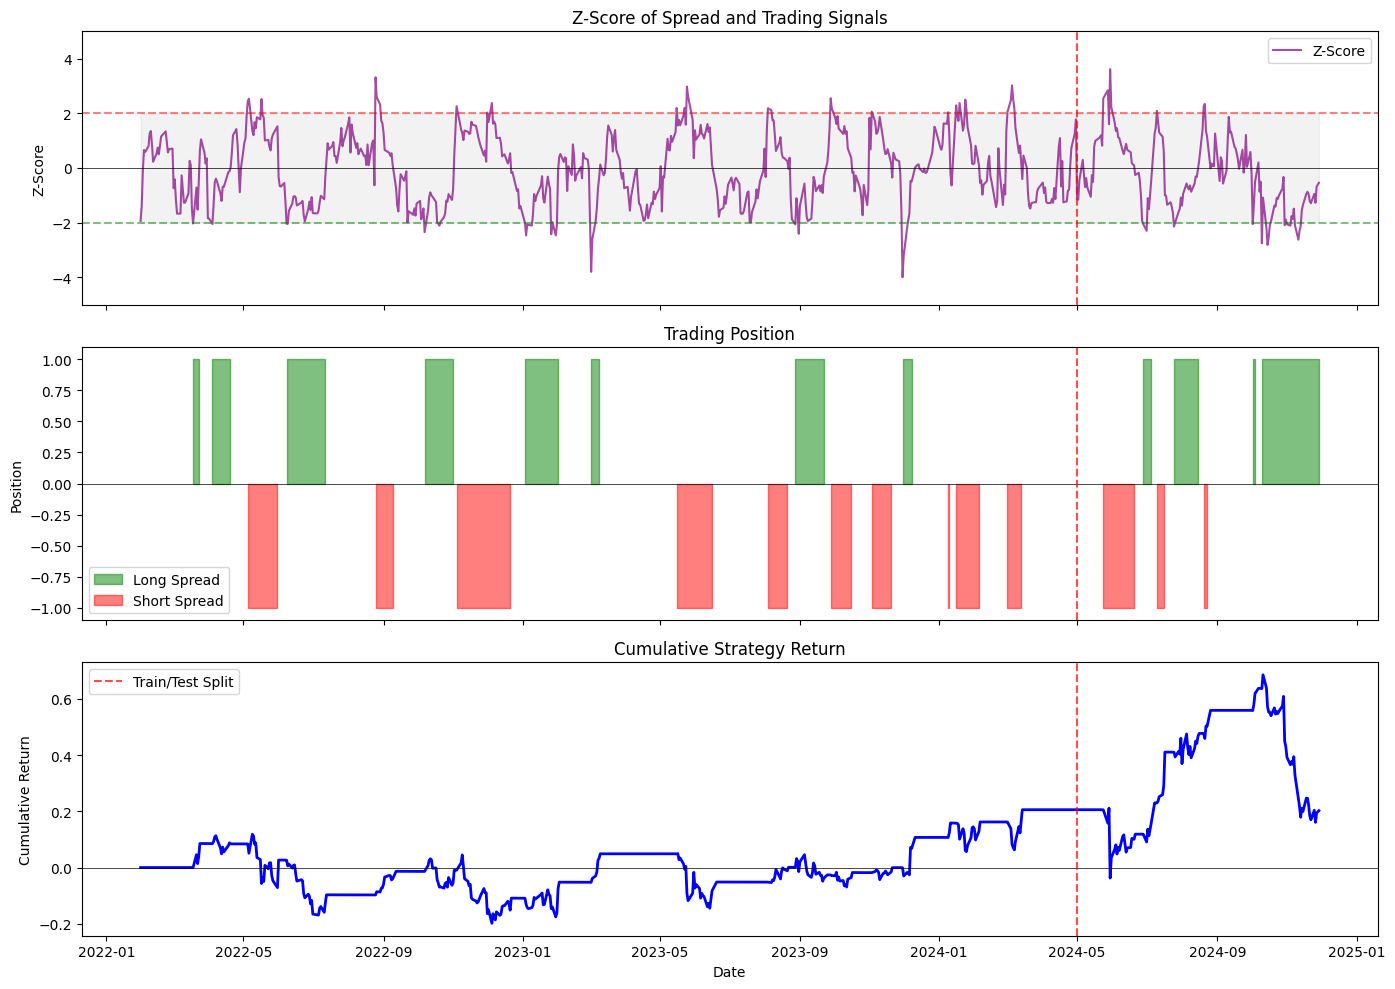

In [26]:
# Trading signal visualization with z-score
if len(backtest_df) > 0 and 'zscore' in backtest_df.columns:
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Z-score with signals
    axes[0].plot(backtest_df['zscore'], color='purple', alpha=0.7, label='Z-Score')
    axes[0].axhline(2, color='red', linestyle='--', alpha=0.5)
    axes[0].axhline(-2, color='green', linestyle='--', alpha=0.5)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[0].fill_between(backtest_df.index, -2, 2, alpha=0.1, color='gray')
    if len(train_data) > 0:
        axes[0].axvline(train_end_date, color='red', linestyle='--', alpha=0.7)
    axes[0].set_ylabel('Z-Score')
    axes[0].set_title('Z-Score of Spread and Trading Signals')
    axes[0].legend()
    axes[0].set_ylim(-5, 5)
    
    # Position
    axes[1].fill_between(backtest_df.index, 0, backtest_df['signal'], 
                          where=backtest_df['signal'] > 0, color='green', alpha=0.5, label='Long Spread')
    axes[1].fill_between(backtest_df.index, 0, backtest_df['signal'], 
                          where=backtest_df['signal'] < 0, color='red', alpha=0.5, label='Short Spread')
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
    if len(train_data) > 0:
        axes[1].axvline(train_end_date, color='red', linestyle='--', alpha=0.7)
    axes[1].set_ylabel('Position')
    axes[1].set_title('Trading Position')
    axes[1].legend()
    
    # Cumulative P&L
    axes[2].plot(np.exp(strategy_cum) - 1, color='blue', linewidth=2)
    axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
    if len(train_data) > 0:
        axes[2].axvline(train_end_date, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[2].set_ylabel('Cumulative Return')
    axes[2].set_xlabel('Date')
    axes[2].set_title('Cumulative Strategy Return')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: Cannot plot signals - no backtest data available.")


In [27]:
# Summary statistics table
print("\n" + "="*60)
print("STRATEGY SUMMARY")
print("="*60)
print(f"\nPair Traded: {stock1} / {stock2}")
print(f"Sector: {sector_map.get(stock1, 'Unknown')}")
print(f"Hedge Ratio: {hedge_ratio:.4f}")
print(f"\nTrading Parameters:")
print(f"  - Entry Threshold: +/- {entry_threshold} standard deviations")
print(f"  - Exit Threshold: {exit_threshold} (mean reversion)")
print(f"  - Lookback Window: {lookback} days")
print(f"  - Transaction Cost: {fee_rate:.2%} per trade")
print(f"\nTotal Trades: {num_trades}")
print(f"Average Holding Period: {len(backtest_df) / max(num_trades/2, 1):.1f} days")

# Out-of-sample is the true test of strategy viability
print("\n" + "="*60)
print("KEY RESULT: OUT-OF-SAMPLE PERFORMANCE")
print("="*60)
if len(test_results) > 0:
    oos_sharpe = sharpe_ratio(test_results['strategy_return_net'])
    oos_return = np.exp(test_results['strategy_return_net'].cumsum().iloc[-1]) - 1
    print(f"\n  Sharpe Ratio: {oos_sharpe:.2f}")
    print(f"  Total Return: {oos_return:.2%}")
    
    if oos_sharpe > 1:
        print("\n  -> Strategy shows promise with Sharpe > 1")
    elif oos_sharpe > 0:
        print("\n  -> Strategy is profitable but Sharpe < 1")
    else:
        print("\n  -> Strategy did not perform well out-of-sample")
else:
    print("\n  No out-of-sample data available")



STRATEGY SUMMARY

Pair Traded: AMD / CRM
Sector: Technology
Hedge Ratio: 0.7133

Trading Parameters:
  - Entry Threshold: +/- 2.0 standard deviations
  - Exit Threshold: 0.0 (mean reversion)
  - Lookback Window: 20 days
  - Transaction Cost: 0.02% per trade

Total Trades: 49
Average Holding Period: 29.1 days

KEY RESULT: OUT-OF-SAMPLE PERFORMANCE

  Sharpe Ratio: -0.01
  Total Return: -0.28%

  -> Strategy did not perform well out-of-sample


---
# PAPER: Pairs Trading Strategy Using Cointegration Analysis
## IEOR 198 Final Project
---

## Abstract

This paper presents a market-neutral pairs trading strategy based on cointegration analysis of S&P 500 stocks. The strategy identifies statistically related stock pairs within the same sector and generates trading signals when their price relationship diverges from historical norms. Using the Engle-Granger cointegration test to screen for viable pairs and z-score-based entry/exit rules, we backtest the strategy over a multi-year period with an 80/20 train-test split. We account for transaction costs and evaluate performance using Sharpe ratio, total returns, and maximum drawdown. The results demonstrate the viability of statistical arbitrage approaches while highlighting the challenges of maintaining cointegration relationships out-of-sample.


## 1. Introduction

### Background

Pairs trading is a classic market-neutral strategy that has been employed by quantitative hedge funds since the 1980s, pioneered by Nunzio Tartaglia's quantitative group at Morgan Stanley. The fundamental premise is simple: identify two securities whose prices have historically moved together, and when they temporarily diverge, bet on their convergence.

### Why Pairs Trading?

Unlike directional strategies that profit from market movements, pairs trading aims to be **market neutral** - insulated from broad market swings. This is achieved by simultaneously holding a long position in one stock and a short position in another. The profit comes not from the overall market direction, but from the *relative* movement between the two securities.

### Cointegration vs Correlation

A critical distinction in pairs trading is between **correlation** and **cointegration**:

- **Correlation** measures how two price series move together over time. However, two correlated stocks can drift apart permanently.
- **Cointegration** is a stronger statistical property indicating that two non-stationary series share a common stochastic trend. If cointegrated, their spread (linear combination) is stationary and will revert to a mean.

We use cointegration as our primary screening criterion because it provides a theoretical basis for mean reversion, which is the core assumption of pairs trading.

### Objectives

1. Screen S&P 500 stocks for cointegrated pairs within the same sector
2. Develop a systematic trading strategy based on z-score signals
3. Backtest the strategy with realistic transaction costs
4. Evaluate out-of-sample performance to assess strategy robustness


## 2. Dataset

### Data Source

We use **Yahoo Finance** (via the `yfinance` Python library) to obtain historical adjusted closing prices for S&P 500 constituent stocks. Adjusted close prices account for stock splits and dividends, providing a more accurate representation of total returns.

### Universe Selection

To make pair screening computationally tractable and fundamentally sound, we focus on 40 stocks from four sectors:
- **Technology** (10 stocks): AAPL, MSFT, GOOGL, META, NVDA, AMD, INTC, CRM, ADBE, ORCL
- **Financial** (10 stocks): JPM, BAC, WFC, GS, MS, C, USB, PNC, TFC, COF
- **Consumer Discretionary** (10 stocks): AMZN, TSLA, HD, MCD, NKE, SBUX, TGT, LOW, TJX, ROST
- **Energy** (10 stocks): XOM, CVX, COP, SLB, EOG, MPC, PSX, VLO, OXY, HAL

### Time Period

- **Full Period**: January 2022 - December 2024 (approximately 3 years)
- **Training Set** (80%): Used for cointegration testing and parameter estimation
- **Test Set** (20%): Used for out-of-sample performance evaluation

### Data Processing

1. Downloaded daily adjusted close prices for all 40 tickers
2. Removed tickers with missing data during the period
3. Calculated log returns: $r_t = \ln(P_t / P_{t-1})$
4. Aligned all time series to common trading days
